In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64",True)
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
plt.style.use("ggplot")

In [2]:
B = jax.random.normal(jax.random.PRNGKey(13),(500,1050))
A = B[:,:1000]
def A_svd():
    return jnp.linalg.svd(A)[0]

def B_svd():
    return jnp.linalg.svd(B)[0]

Amod = jnp.hstack([A,jnp.zeros((500,1025 - A.shape[1]))])
def padded_svd():
    return jnp.linalg.svd(Amod)[0]

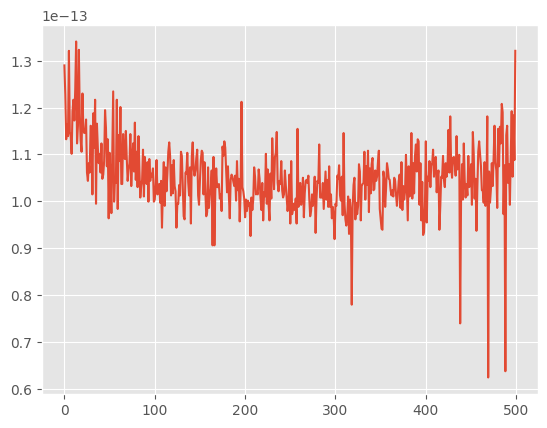

In [3]:
modsvd = jnp.linalg.svd(Amod)
svd = jnp.linalg.svd(A)
plt.plot(jnp.diag(jnp.abs(modsvd.U.T@svd.U)) - 1)

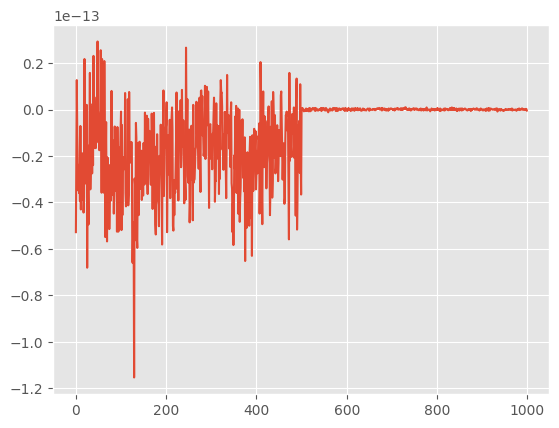

In [4]:
plt.plot(jnp.abs(jnp.diag(modsvd.Vh[:1000,:1000]@svd.Vh.T)) - 1)

In [5]:
%time A_svd().block_until_ready()  # measure JAX compilation time
%timeit A_svd().block_until_ready()  # measure JAX runtime

CPU times: user 236 ms, sys: 7.42 ms, total: 243 ms
Wall time: 243 ms
226 ms ± 80.9 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%time B_svd().block_until_ready()  # measure JAX compilation time
%timeit B_svd().block_until_ready()  # measure JAX runtime

CPU times: user 80.3 ms, sys: 7.93 ms, total: 88.2 ms
Wall time: 101 ms
72 ms ± 23 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
%time padded_svd().block_until_ready()  # measure JAX compilation time
%timeit padded_svd().block_until_ready()  # measure JAX runtime

CPU times: user 53.6 ms, sys: 19.4 ms, total: 73 ms
Wall time: 74.5 ms
71.5 ms ± 38.9 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
A.shape[0]

450

In [23]:
def pad_1025(A):
    padding_shape = jnp.array(A.shape)
    pad_index = jnp.argmax(padding_shape)
    padding_shape = padding_shape.at[jnp.argmax(padding_shape)].set(jnp.maximum(0,1025 - padding_shape[jnp.argmax(padding_shape)]))
    return jnp.concat([A,jnp.zeros(padding_shape)],axis = pad_index)

def pad_SVD(A):
    orig_shape = A.shape
    pad_A = pad_1025(A)
    U,sigma,Vt = jnp.linalg.svd(pad_A)
    print(orig_shape)
    return U[:orig_shape[0],:orig_shape[0]],sigma,Vt[:orig_shape[1],:orig_shape[1]]

In [30]:
A = A[:800]
shape = A.shape
U,sigma,Vt = pad_SVD(A)

(450, 4000)


Array([[-8.10285122e-03,  1.49926352e-03, -1.26047238e-02, ...,
        -2.41206453e-02, -1.92014879e-02, -1.29698130e-02],
       [-1.31163446e-02, -1.11409021e-02, -2.83098368e-04, ...,
         1.19812888e-02,  2.09108045e-02,  1.04508855e-03],
       [ 1.88914283e-02,  2.33730618e-02,  3.81142782e-03, ...,
        -4.30994687e-03, -2.43133465e-02, -3.66861812e-03],
       ...,
       [ 1.27951896e-02, -1.03314327e-02, -1.72886691e-02, ...,
         8.72310081e-01, -5.84862212e-03, -2.89292291e-03],
       [-1.36837482e-02,  2.36177446e-02, -7.49425299e-03, ...,
        -4.26028738e-03,  8.91870982e-01,  7.62952543e-03],
       [ 1.97259475e-02,  1.34163621e-02, -1.45125673e-02, ...,
        -4.20634304e-03,  5.63032791e-03,  8.91945068e-01]],      dtype=float64)

In [17]:
n = 450
m = 4000
A = jax.random.normal(jax.random.PRNGKey(13),(n,m))
import time
computation_times = {'double':[],'single':[],'padded':[]}
matrix_widths = range(100,m,25)
for k in tqdm(matrix_widths):
    B = A[:,:k]
    durations = []
    for i in range(5):
        start = time.time()
        svd = jnp.linalg.svd(B)[0].block_until_ready()
        end = time.time()
        duration = end - start
        durations.append(duration)
    computation_times['double'].append(jnp.mean(jnp.array(durations)))

    durations = []
    for i in range(5):
        start = time.time()
        svd = pad_SVD(B)[0]#.block_until_ready()
        end = time.time()
        duration = end - start
        durations.append(duration)
    computation_times['padded'].append(jnp.mean(jnp.array(durations)))
    
    B = jnp.array(B,dtype = 'float32')
    durations = []
    for i in range(5):
        start = time.time()
        svd = jnp.linalg.svd(B)[0].block_until_ready()
        end = time.time()
        duration = end - start
        durations.append(duration)
    computation_times['single'].append(jnp.mean(jnp.array(durations)))

algs = ['single','double','padded']
for alg in algs:
    plt.plot(matrix_widths,computation_times['alg'],label = 'alg')
plt.xlabel("width of matrix")
plt.ylabel("Time for SVD")
plt.title(f"SVD time for fixed height = {n}")
plt.show()

  0%|          | 0/156 [00:00<?, ?it/s]

IndexError: Array slice indices must have static start/stop/step to be used with NumPy indexing syntax. Found slice(None, (), None). To index a statically sized array at a dynamic position, try lax.dynamic_slice/dynamic_update_slice (JAX does not support dynamically sized arrays within JIT compiled functions).

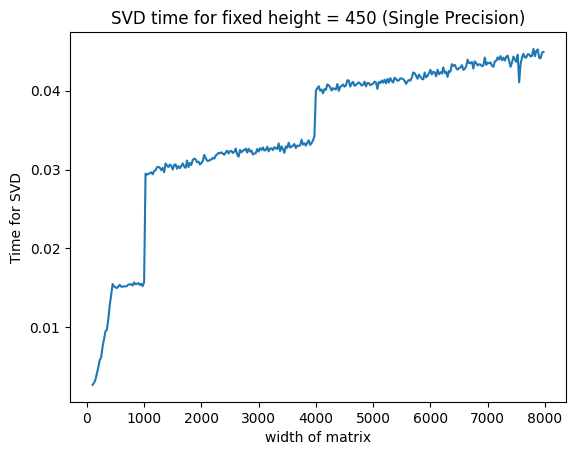

In [13]:
plt.plot(matrix_widths,computation_times)
plt.xlabel("width of matrix")
plt.ylabel("Time for SVD")
plt.title(f"SVD time for fixed height = {n} (Single Precision)")
plt.show()

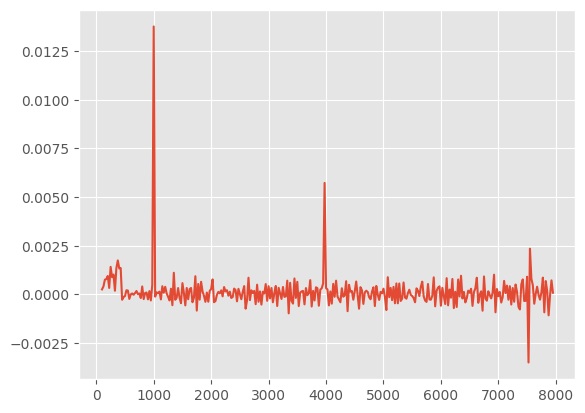

In [20]:
times = jnp.array(computation_times)
plt.plot(jnp.array(list(matrix_widths))[:-1],jnp.diff(times))